#Import all the libraries

In [ ]:
!pip install mtcnn

# demonstrate face detection on 5 Celebrity Faces Dataset
import tensorflow as tf
import os
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from numpy import load
from numpy import expand_dims
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
from os import listdir
from os.path import isdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


     |████████████████████████████████| 2.3 MB 8.3 MB/s 


#This function is for detecting and extracting the face out of a given image

In [ ]:
def extract_face(filename, required_size=(160, 160)):
	# load image from file
  image = Image.open(filename)
	# convert to RGB, if needed
  image = image.convert('RGB')
	# convert to array
  pixels = asarray(image)
	# create the detector, using default weights
  detector = MTCNN()
	# detect faces in the image
  results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
  x1, y1, width, height = results[0]['box']
	# bug fix
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1 + width, y1 + height
	# extract the face
  face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  # print(face_array)
  return face_array


#This function is for loading the images from a given directory

In [ ]:
def load_faces(directory,data_storage,subdir):
  faces = list()
	# enumerate files
  for filename in listdir(directory):
		# path
    path = directory + filename
		# get face
    face = extract_face(path,required_size=(160,160))
		# store 
    data_storage.append((face,subdir))
    

#This function is for loading the dataset

In [ ]:
def load_dataset(directory,data_storage):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		load_faces(path,data_storage,subdir)
		# summarize progress
		print('>loaded images for class: %s' % (subdir))
		
 
# load train dataset
data = []
load_dataset('data_1/data/train/',data)
df = pd.DataFrame(data, columns=["image", "name"])
print("Length:",len(df))

# load test dataset
data = []
load_dataset('data_1/data/val/',data)
df_test = pd.DataFrame(data, columns=["image", "name"])
print("Test size: ", len(df_test))

>loaded images for class: ben_afflek
>loaded images for class: elton_john
>loaded images for class: mindy_kaling
>loaded images for class: madonna
>loaded images for class: jerry_seinfeld
Length: 93
>loaded images for class: ben_afflek
>loaded images for class: jerry_seinfeld
>loaded images for class: mindy_kaling
>loaded images for class: elton_john
>loaded images for class: madonna
Test size:  25


In [ ]:
le = LabelEncoder()
le.fit(df["name"].values)

LabelEncoder()

#Load the train dataset

In [ ]:
x_train = list(df.image.values)
x_train = np.array(x_train)
x_train = x_train/255
print(x_train.shape)

y_train = le.transform(df["name"].values)
print(y_train.shape)

(93, 160, 160, 3)
(93,)


#Load the test dataset

In [ ]:
x_test = list(df_test.image.values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(df_test["name"].values)
print(y_test.shape)

(25, 160, 160, 3)
(25,)


#Training without triplet loss model

In [ ]:
def get_model():
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(160,160,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(256, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(5, activation="softmax"))

        model.summary()
        return model


model = get_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1440 (Conv2D)         (None, 80, 80, 64)        1792      
_________________________________________________________________
conv2d_1441 (Conv2D)         (None, 40, 40, 128)       73856     
_________________________________________________________________
conv2d_1442 (Conv2D)         (None, 20, 20, 64)        73792     
_________________________________________________________________
conv2d_1443 (Conv2D)         (None, 10, 10, 64)        4160      
_________________________________________________________________
flatten_240 (Flatten)        (None, 6400)              0         
_________________________________________________________________
dense_840 (Dense)            (None, 256)               1638656   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [ ]:
weight_dir = "weights-normal-model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')
model.fit(x_train,y_train,validation_data=(x_test, y_test),epochs=50, batch_size=100, callbacks=[checkpoint])

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 1.6075 - accuracy: 0.2581 - val_loss: 1.5914 - val_accuracy: 0.2000
Epoch 2/50
1/1 [==============================] - 0s 122ms/step - loss: 1.5896 - accuracy: 0.2366 - val_loss: 1.5940 - val_accuracy: 0.2000
Epoch 3/50
1/1 [==============================] - 0s 107ms/step - loss: 1.5356 - accuracy: 0.2581 - val_loss: 1.5654 - val_accuracy: 0.3200
Epoch 4/50
1/1 [==============================] - 0s 109ms/step - loss: 1.5300 - accuracy: 0.3656 - val_loss: 1.4673 - val_accuracy: 0.4400
Epoch 5/50
1/1 [==============================] - 0s 118ms/step - loss: 1.4275 - accuracy: 0.5376 - val_loss: 1.3501 - val_accuracy: 0.4400
Epoch 6/50
1/1 [==============================] - 0s 116ms/step - loss: 1.3701 - accuracy: 0.4516 - val_loss: 1.3146 - val_accuracy: 0.5200
Epoch 7/50
1/1 [==============================] - 0s 116ms/step - loss: 1.2844 - accuracy: 0.5591 - val_loss: 1.2840 - val_accuracy: 0.3600
Epoch 8/50
1/1 [=======

#Training with triplet loss model

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [ ]:
def generate_triplets(batch_size = 256):

    # all of these numpy arrays are of same size
    anchors,positives,negatives   = np.zeros((batch_size, 160, 160, 3)), np.zeros((batch_size, 160, 160, 3)), np.zeros((batch_size, 160, 160, 3))
    
    for i in range(0, batch_size):
        # generating random number between 0 and 60000(total number of images)
        index = random.randint(0, x_train.shape[0] - 1)

        # indexe for anchor image and it's label
        anchor   = x_train[index]
        y     = y_train[index]
        
        # list of positive label indexes
        index_pos = np.where(y_train == y)
        index_pos = np.squeeze(index_pos)

        # list of negative label indexes 
        index_neg = np.where(y_train != y)
        index_neg = np.squeeze(index_neg)

        # length of positive list containing indexes
        len_pos = len(index_pos)

        # length of negative list containing indexes
        len_neg = len(index_neg)

        # randomly selecting any single image from all the list of indexes
        positive = x_train[index_pos[random.randint(0, len_pos - 1)]]
        negative = x_train[index_neg[random.randint(0, len_neg - 1)]]
        
        
        anchors[i], positives[i], negatives[i]   = anchor, positive, negative

    return anchors, positives, negatives

In [ ]:
# anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 10, num_diff=10)
anchor_images, same_images, diff_images = generate_triplets(batch_size=2000)
print(anchor_images.shape, same_images.shape, diff_images.shape)

(2000, 160, 160, 3) (2000, 160, 160, 3) (2000, 160, 160, 3)


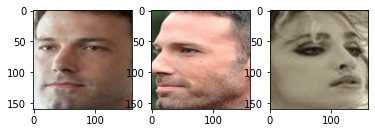

In [ ]:
idx = 90
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])

In [ ]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(160,160,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [ ]:
anchor_input = tf.keras.layers.Input((160, 160, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((160, 160, 3), name='positive_input')
negative_input = tf.keras.layers.Input((160, 160, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],
                                            axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1444 (Conv2D)         (None, 80, 80, 64)        1792      
_________________________________________________________________
conv2d_1445 (Conv2D)         (None, 40, 40, 128)       73856     
_________________________________________________________________
conv2d_1446 (Conv2D)         (None, 20, 20, 64)        73792     
_________________________________________________________________
conv2d_1447 (Conv2D)         (None, 10, 10, 64)        4160      
_________________________________________________________________
flatten_241 (Flatten)        (None, 6400)              0         
_________________________________________________________________
dense_843 (Dense)            (None, 512)               3277312   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [ ]:
weight_dir = "weights-tripletloss-model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')
Y_dummy = np.empty((anchor_images.shape[0],1))

model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=100, callbacks=[checkpoint])

Epoch 1/100
16/16 [==============================] - 8s 305ms/step - loss: 21.7741
Epoch 2/100
16/16 [==============================] - 4s 251ms/step - loss: 9.1392
Epoch 3/100
16/16 [==============================] - 4s 248ms/step - loss: 2.7457
Epoch 4/100
16/16 [==============================] - 4s 248ms/step - loss: 1.2230
Epoch 5/100
16/16 [==============================] - 4s 245ms/step - loss: 0.3591
Epoch 6/100
16/16 [==============================] - 4s 243ms/step - loss: 0.9115
Epoch 7/100
16/16 [==============================] - 4s 248ms/step - loss: 0.5791
Epoch 8/100
16/16 [==============================] - 4s 243ms/step - loss: 0.3440
Epoch 9/100
16/16 [==============================] - 4s 245ms/step - loss: 1.5401
Epoch 10/100
16/16 [==============================] - 4s 243ms/step - loss: 0.4347
Epoch 11/100
16/16 [==============================] - 4s 244ms/step - loss: 0.2770
Epoch 12/100
16/16 [==============================] - 4s 244ms/step - loss: 0.2180
Epoch 13/100

#Plotting the graph after training

In [ ]:
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)
pred = anchor_model.predict(x_train)
pred.shape

(93, 128)

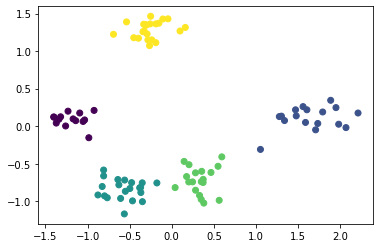

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

In [ ]:
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [ ]:
name_dict = {}
for i in set(df["name"].values):
    z = df[df["name"] == i].image
    img = np.array(list(z))/255
    enc = np.zeros((1,128))
    for j in range(len(z)):
        enc += encode_image(anchor_model,img[j])

    enc = enc/len(z)
    name_dict[i] = enc

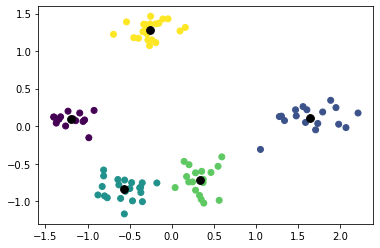

In [ ]:
pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

for val in name_dict.values():
  point = pca.transform(val)
  plt.scatter(point[0,0], point[0,1], s = [60], c='black')
plt.show()

#Predicting the images 

In [ ]:
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

Predicted name: madonna  with distance 0.2556441449881512
Actual pred:  ['madonna']


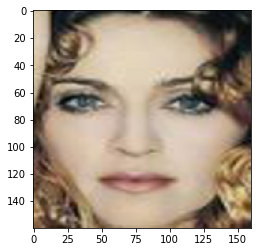

In [ ]:
idx = 70
img = x_train[idx]
plt.imshow(img)

n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",n ," with distance", d)
print("Actual pred: ", le.inverse_transform(y_train[idx:idx+1]))